# Action PixelBytes: Catching Insights in Unified Multimodal Sequences

## Description

**PixelBytes** est un modèle conçu pour générer simultanément du texte, des images, des animations pixel par pixel et des actions-états sous forme de séquences. L'objectif de ce projet est d'explorer un embedding unifié permettant une génération multimodale cohérente, facilitant ainsi l'interaction entre différentes formes de données. [Dépôt GitHub PixelBytes](https://github.com/fabienfrfr/PixelBytes)

## Dataset

Pour ce projet, nous utilisons un dataset créé à partir d'un contrôle optimal LQG (combinant LQR et un filtre de Kalman) sur des systèmes LTI contrôlables, stables et observables.

## Test

Nous testons la génération d'un problème de contrôle à partir d'un environnement Gym personnalisé pour les systèmes LTI. [Dépôt GitHub Gym-Setpoint](https://github.com/fabienfrfr/Gym-Setpoint)

In [1]:
!pip install -q git+https://github.com/fabienfrfr/PixelBytes.git@main
!pip install -q -U git+https://github.com/fabienfrfr/Gym-Setpoint@main

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.15 requires gymnasium==0.29.0, but you have gymnasium 0.29.1 which is incompatible.


In [2]:
import gymnasium as gym
import gym_setpoint
# custom import
from gym_setpoint.envs import gym_wrap, lti_env, multi_lti
from pixelbytes import *
from datasets import load_dataset
import pylab as plt
from tqdm import tqdm

In [3]:
dataset = load_dataset("ffurfaro/PixelBytes-OptimalControl")['train']
dataset

README.md:   0%|          | 0.00/372 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9370 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'text'],
    num_rows: 9370
})

In [4]:
DATA_REDUCTION = {"image":1, "audio":1} # important pour la proportion des data en AR (overfitting audio risk)
#tokenizer = ActionPixelBytesTokenizer(data_slicing=DATA_REDUCTION)
MIN_BYTES = [b'\x00', b'\t', b'\n', b'0', b'1']
MIN_PALETTE = generate_palette(num_colors=5)
ACTION_STATE= generate_action_space(141)
tokenizer = ActionPixelBytesTokenizer(BYTES=MIN_BYTES, PALETTE=MIN_PALETTE, ACTION_STATE=ACTION_STATE, data_slicing=DATA_REDUCTION)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


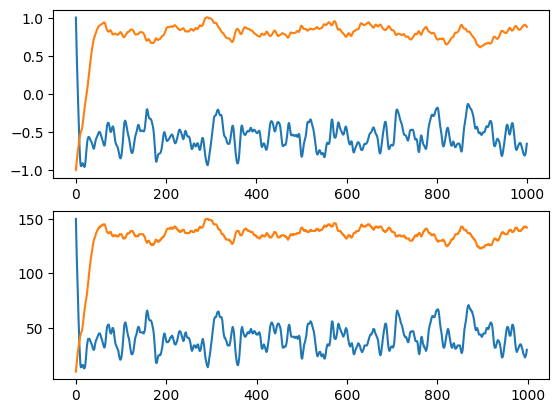

In [5]:
row = np.random.randint(dataset.num_rows)
timestamp = dataset[row]['audio']
# comparizons
tokenstamp = tokenizer(audio=timestamp)
fig, ax = plt.subplots(2)
ax[0].plot(timestamp['array'].T)
ax[1].plot(tokenstamp["labels"].detach().reshape(-1,2)[:-2]); plt.show()

In [6]:
model = aPxBySequenceModel.from_pretrained("ffurfaro/aPixelBytes-OptimalControl", subfolder="bilstm_diffusion_last")
model.config

bilstm_diffusion_last/config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

(…)tm_diffusion_last/generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

ModelConfig {
  "_name_or_path": "ffurfaro/aPixelBytes-OptimalControl",
  "architectures": [
    "aPxBySequenceModel"
  ],
  "bidirection": true,
  "custom_model": null,
  "embed_size": 126,
  "hidden_size": 128,
  "num_diffusion_steps": 5,
  "num_layers": 2,
  "objective": "diffusion",
  "pxby_dim": 6,
  "pxby_emb": 21,
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "vocab_size": 151
}

In [7]:
# Create and use LTI-Env
env = lti_env.LtiEnv(custom_config={"env_mode":0, "reset_X_start":False, "tf":[([1],[1,1])],
                                    "setpoint": 0.5,  "t":20,"N":1000+2})
print(env.ss, env.config['tf'], env.setpoint, env.sign)
env.config

i           1
s           1
A    [[-1.0]]
B     [[1.0]]
C     [[1.0]]
D     [[0.0]]
dtype: object [([1], [1, 1])] 0.5 1.0


{'env_mode': 0,
 'update_setpoint': True,
 'reset_X_start': False,
 'tf': [([1], [1, 1])],
 'reset': True,
 'isdiscrete': False,
 'SpaceState': None,
 'setpoint': 0.5,
 'env_config': None,
 'modular': False,
 'return_action': True,
 'return_speed': False,
 'order': 3,
 't': 20,
 'N': 1002}

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams.update({'font.size': 16}) 

def run_simulations(env, model, tokenizer, n_simulations=10, n_steps=251, scaler=2, repeat=3, mean=False):
    all_obs = []
    for _ in tqdm(range(n_simulations), desc="Running simulations"):
        observation, _ = env.reset()
        obs, action, sim_obs = [observation], 0, []
        for i in range(n_steps):
            if i < model.config.hidden_size and i % scaler == 0:
                action = (action + 0.8*env.sign*np.sign(np.diff(observation[-2:])) + 0.2*env.action_space.sample())/2
            elif i >= model.config.hidden_size:
                wanted_obs = obs + repeat*[np.array([0,0,observation[-1],0])]
                tokenstamp = tokenizer(audio={'array': np.stack(wanted_obs).T[[0,2]]})
                in_model = tokenstamp['input_ids'][None, :-1]
                targets = list(range(in_model.shape[1]-2*repeat, in_model.shape[1], 2))
                action_tokens = model.generate(in_model, idn_generator=targets, temperature=0.1).detach().int()[0,targets,-1]
                action = [np.mean(tokenizer.convert_ids_to_tokens(action_tokens))] if mean else [tokenizer._convert_id_to_token(int(action_tokens[0]))]
            observation, _, _, _, _ = env.step(action)
            sim_obs.append(observation[[0,2]])
            obs.append(observation)
        all_obs.append(sim_obs)
    df = pd.DataFrame(all_obs).applymap(list)
    df.to_csv('simulation_results.csv', index=False)
    return df, model.config.hidden_size


# Usage example:
n_simulations = 20
df, transition_point = run_simulations(env, model, tokenizer, n_simulations=n_simulations)

Running simulations: 100%|██████████| 20/20 [07:36<00:00, 22.84s/it]
/tmp/ipykernel_30/3802165271.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = pd.DataFrame(all_obs).applymap(list)
